<a href="https://colab.research.google.com/github/SashaSBonacina/PET-Alzheimer-Prediction-Thesis/blob/main/BAE_18_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

## Importing libraries

In [2]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2, re, itertools,pathlib
from skimage import transform
import scipy.ndimage as ndi
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


## Mounting google drive to access the data

In [3]:
drive.mount('/content/drive') #mounting drive

Mounted at /content/drive


## Loading in CSV with Image ID, Age, Sex

In [4]:
cols = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Description', 'Type', 'Acq Date'] # we dont need all the columns
df = pd.read_csv('/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN.csv', usecols = cols)
df.columns = ['ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit',
       'Descrip', 'Type', 'Acq Date'] # renaming cols


In [5]:
df.head()

,ID,Subject,Group,Sex,Age,Visit,Descrip,Type,Acq Date
0,I387827,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/27/2013
1,I388229,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy2 4i/16s AV45,Original,8/30/2013
2,I509380,024_S_4158,CN,M,88,v41,[F-18]AV-45 Dy1 4i/16s AV45,Original,9/03/2015
3,I388228,024_S_4158,CN,M,86,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/30/2013
4,I387826,024_S_4084,CN,F,71,v21,[F-18]AV-45 Dy1 4i/1 Early AV45,Original,8/27/2013


Collecting file paths with the images

In [6]:
directory = '/content/drive/MyDrive/CN FOR BAE DATA/Tx_Origin_SpatNORM_CN_imageID' # enter the dir were the images are stored
image_ids = []
for filename in os.listdir(directory):
  image_ids.append(filename)
print(len(image_ids))

102


In [7]:
df = df[df['ID'].isin(image_ids)] #filterring the df so it only contains the data we need
df = df.reset_index()

In [8]:
df.shape

(102, 10)

Adding the image paths to the df for the corresponding image ID

In [9]:
# new colunm for the paths
df['Loc'] = ''
# iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    image_id_folder = filename

    for image in os.listdir(f):
      f = os.path.join(f, image)
      if os.path.isfile(f) and f.endswith('nii'):  # checking if it is a file and a .nii file
          df.loc[df['ID']==image_id_folder, 'Loc' ] = f # appending the path

In [10]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'M' else -1)

# Data Information (vis)

## Bar graphs

In [ ]:
df['Shape'] = df['Loc'].apply(lambda x: nib.load(x).get_fdata().shape) # adding the shape of each image as a feature
df['Type'] = df['Loc'].apply(lambda x: type(nib.load(x))) # adding the type of each image as a feature

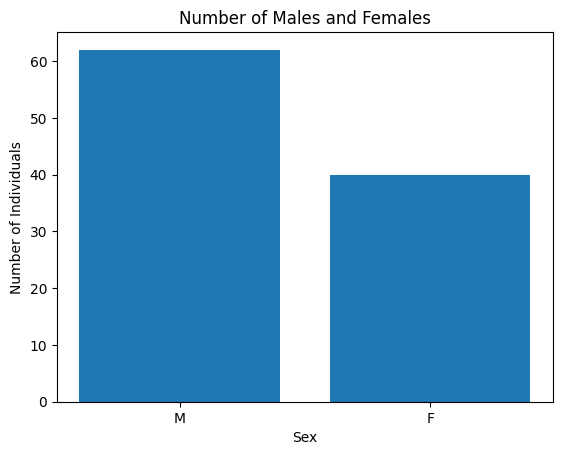

In [ ]:
sex_counts = df["Sex"].value_counts()
# Plot the bar chart
plt.bar(sex_counts.index, sex_counts.values)
plt.xlabel("Sex")
plt.ylabel("Number of Individuals")
plt.title("Number of Males and Females")
plt.show()

Text(0.5, 1.0, 'Age Distribution')

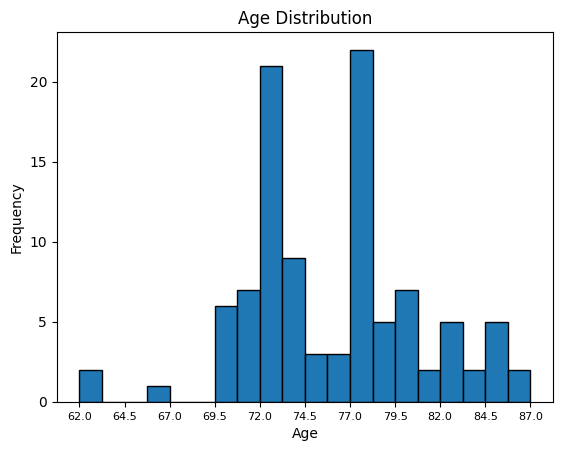

In [ ]:
plt.hist(df["Age"], bins=20, edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Frequency")
num_ticks = 11  # The number of ticks you want
x_ticks = np.linspace(df["Age"].min(), df["Age"].max(), num_ticks)
plt.xticks(x_ticks, fontsize=8)

plt.title("Age Distribution")

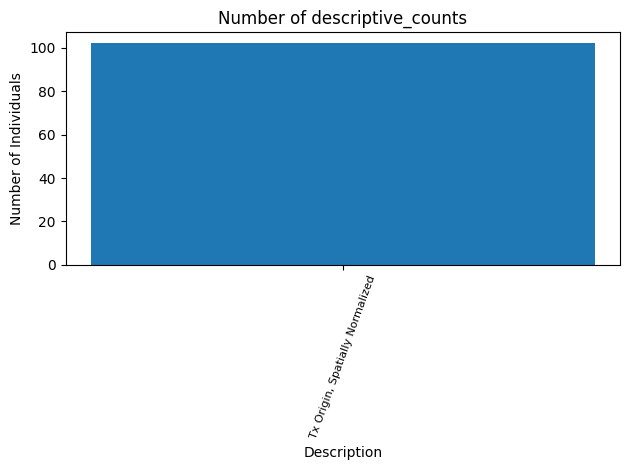

In [ ]:
descriptive_counts = df["Descrip"].value_counts()
# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Description")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

In [ ]:
len(df['Subject'].unique())

102

Each subject has only 1 image in the df

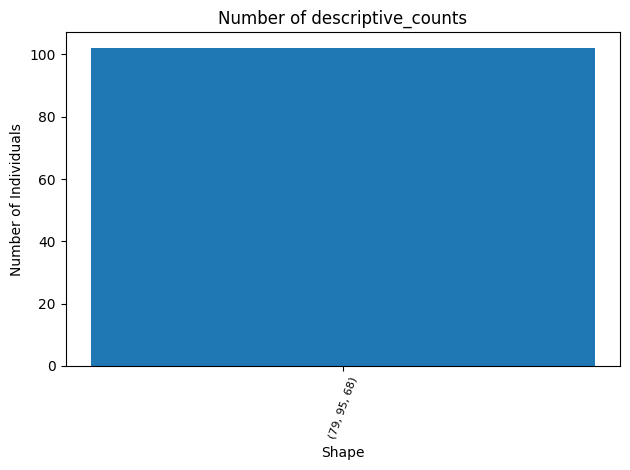

In [ ]:
descriptive_counts = df["Shape"].astype(str).value_counts()

# Plot the bar chart
plt.bar(descriptive_counts.index, descriptive_counts.values)
plt.xlabel("Shape")
plt.ylabel("Number of Individuals")
plt.title("Number of descriptive_counts")
plt.xticks(fontsize=8, rotation=70)
plt.tight_layout()
plt.show()

No reshaping needed as all are the same shape! This is because the same processing steps were taken by ADNI for each image.

Furthermore each image is 3d not 4d, so t has been average through the image in processing

## Looking at one image

In [ ]:
x = list(df['Loc'])[11] # getting a random image path
brain_vol = nib.load(x)
# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [ ]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

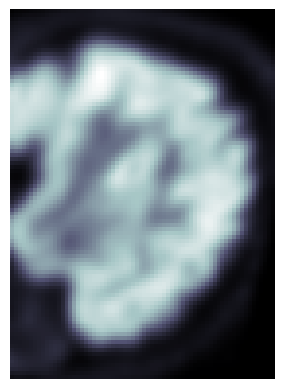

In [ ]:
plt.imshow(brain_vol_data[60], cmap='bone')
plt.axis('off')
plt.show()

# Building some models!

## 3D model

### preparing the data

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import keras
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



Extracting data in the correct format for the model

In [12]:
# Extract image data and corresponding ages from the DataFrame
image_paths = df['Loc'].values
ages = df['Age'].values
sexes = df['Sex'].values

# Initialize empty lists to store image arrays and labels
image_data = []
labels = []

# Loop through each image path, load the image, and append to the lists
for path, age in zip(image_paths, ages):
    image = nib.load(path).get_fdata()
    image_data.append(image)
    labels.append(age)

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Reshape the image data to match the CNN input shape (128, 128, 82, 6) -> (samples, 128, 128, 82, 6)
image_data = image_data.reshape(-1, 79, 95, 68, 1)



In [13]:
count = 0
locations = []
shape = image_data.shape
for a in range(shape[0]):
  for b in range(shape[1]):
    for c in range(shape[2]):
      for d in range(shape[3]):
        if pd.isna(image_data[a][b][c][d]):
          locations.append([a,b,c,d])
          count+=1
print(count)

9677


In [14]:
from collections import Counter
Counter([ele[0] for ele in locations])

Counter({10: 5392, 60: 4285})

In [15]:
5392/(79*95*68)

0.010565505349374926

images 10 and 60 have some nans, as this is only 1% of the image we can replace the pixels with averages

In [16]:
x = list(df['Loc'])[10] # getting a random image path
brain_vol = nib.load(x)
# What is the type of this object?
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [17]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

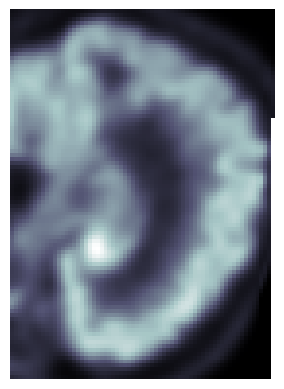

In [18]:
plt.imshow(brain_vol_data[50], cmap='bone')
plt.axis('off')
plt.show()

we can see the nans on the right hand side of the image

In [19]:
for location in locations:
  surrounding_pixels = []
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]-1][location[2]][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]+1][location[2]][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]-1][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]+1][location[3]])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]][location[3]-1])
  except:
    None
  try:
    surrounding_pixels.append(image_data[location[0]][location[1]][location[2]][location[3]+1])
  except:
    None
  image_data[location[0]][location[1]][location[2]][location[3]]  =  np.nanmean(surrounding_pixels)


In [20]:
"""count = 0
shape = image_data.shape
for a in range(shape[0]):
  for b in range(shape[1]):
    for c in range(shape[2]):
      for d in range(shape[3]):
        if pd.isna(image_data[a][b][c][d]):
          locations.append([a,b,c,d])
          count+=1
print(count)"""

'count = 0\nshape = image_data.shape\nfor a in range(shape[0]):\n  for b in range(shape[1]):\n    for c in range(shape[2]):\n      for d in range(shape[3]):\n        if pd.isna(image_data[a][b][c][d]):\n          locations.append([a,b,c,d])\n          count+=1\nprint(count)'

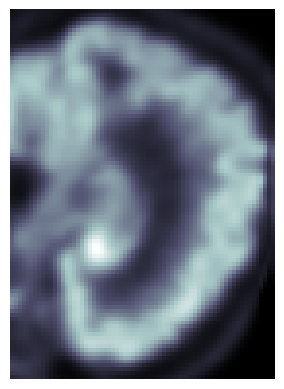

In [21]:
plt.imshow(image_data[10][50], cmap='bone')
plt.axis('off')
plt.show()

th e image data now have no Nans, i have filled in the nana by looking at pixels around the nan

In [22]:
from numpy.random import seed
seed(1)
# Set the random seed
tf.random.set_seed(42)

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(image_data, sexes, ages, test_size=0.2, random_state=42)

In [24]:
image_data.shape

(102, 79, 95, 68, 1)

### Baseline
the baseline will be the average of the ages

In [ ]:
mean_age = np.mean(ages)

In [ ]:
predictions = np.ones(len(test_labels))*mean_age


# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 20.140921074312082
Mean Absolute Error: 3.710084033613445
R-squared: -0.03521517409925745


### V1
model without sex, without transfer learning, ...

In [ ]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 77, 93, 66, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 38, 46, 33, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 36, 44, 31, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 18, 22, 15, 64)   0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 380160)            0         
                                                                 
 dense (Dense)               (None, 32)                1

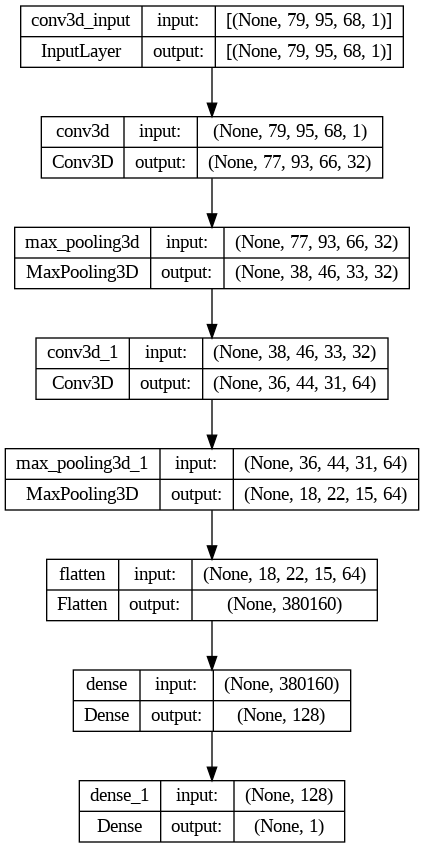

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture


Lets train the model

Epoch 1/100
4/4 [==============================] - 6s 389ms/step - loss: 2808.0569 - val_loss: 836.0582
Epoch 2/100
4/4 [==============================] - 1s 306ms/step - loss: 528.5614 - val_loss: 177.6619
Epoch 3/100
4/4 [==============================] - 1s 306ms/step - loss: 257.0763 - val_loss: 197.1618
Epoch 4/100
4/4 [==============================] - 1s 307ms/step - loss: 154.7242 - val_loss: 194.0791
Epoch 5/100
4/4 [==============================] - 1s 304ms/step - loss: 125.4617 - val_loss: 114.1661
Epoch 6/100
4/4 [==============================] - 1s 305ms/step - loss: 73.1870 - val_loss: 65.5566
Epoch 7/100
4/4 [==============================] - 1s 304ms/step - loss: 52.6357 - val_loss: 30.6552
Epoch 8/100
4/4 [==============================] - 1s 309ms/step - loss: 46.3890 - val_loss: 24.8461
Epoch 9/100
4/4 [==============================] - 1s 308ms/step - loss: 35.4596 - val_loss: 16.8023
Epoch 10/100
4/4 [==============================] - 1s 311ms/step - loss: 27.653

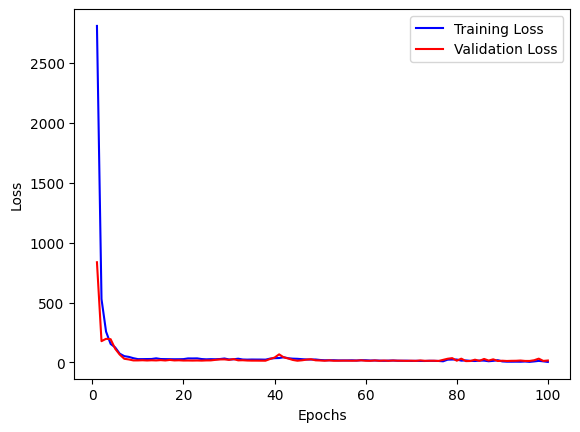

In [ ]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=100, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

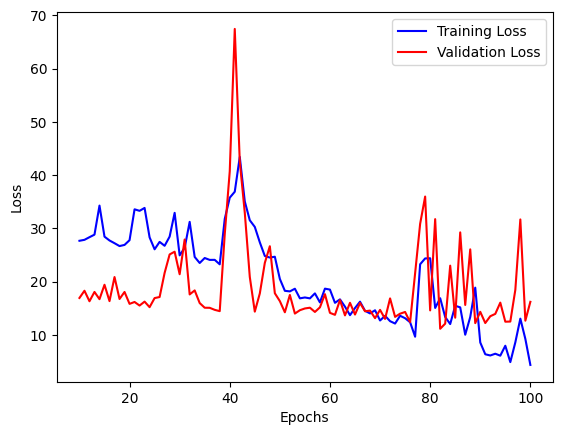

In [ ]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model is unstable and over fits for high epochs

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 0s 200ms/step - loss: 19.4910
Test Loss: 19.491012573242188


In [ ]:
predictions = model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 52ms/step
Mean Squared Error: 19.491012773360126
Mean Absolute Error: 3.2245236351376487
R-squared: -0.0018107963929856474


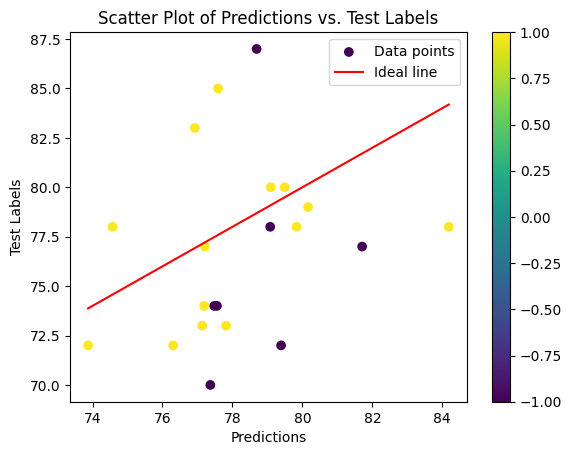

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



In [ ]:
del model
import gc
gc.collect()
tf.keras.backend.clear_session()

We see more males (1) above the line and females below, perhaps adding sex as a feature can improve the model? This will be done later

### V2
Adding early stopping to prevent overfitting

In [ ]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(79, 95, 68, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Lets train the model with early stopping

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_model.h5', monitor='val_loss', save_best_only=True)]

Epoch 1/200
4/4 [==============================] - 6s 877ms/step - loss: 1815.9822 - val_loss: 17.6195
Epoch 2/200
4/4 [==============================] - 1s 308ms/step - loss: 65.1401 - val_loss: 85.7217
Epoch 3/200
4/4 [==============================] - 1s 307ms/step - loss: 76.2787 - val_loss: 24.1464
Epoch 4/200
4/4 [==============================] - 1s 306ms/step - loss: 45.3227 - val_loss: 34.7534
Epoch 5/200
4/4 [==============================] - 1s 309ms/step - loss: 41.3167 - val_loss: 18.3467
Epoch 6/200
4/4 [==============================] - 1s 305ms/step - loss: 33.2154 - val_loss: 23.7530
Epoch 7/200
4/4 [==============================] - 1s 306ms/step - loss: 31.8532 - val_loss: 33.6271
Epoch 8/200
4/4 [==============================] - 1s 310ms/step - loss: 42.9918 - val_loss: 24.5418
Epoch 9/200
4/4 [==============================] - 1s 308ms/step - loss: 32.6458 - val_loss: 18.5745
Epoch 10/200
4/4 [==============================] - 1s 306ms/step - loss: 31.1114 - val_l

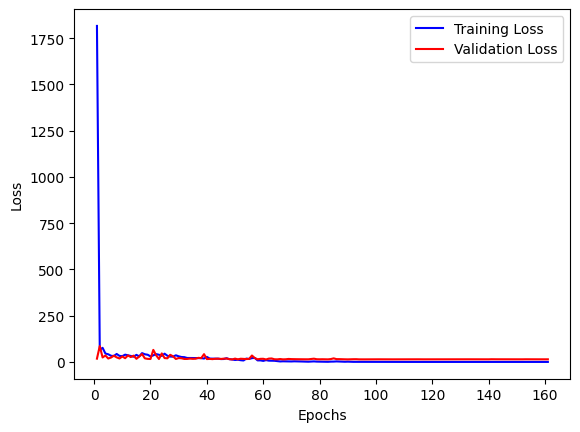

In [ ]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=200, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Zoom in on the graph

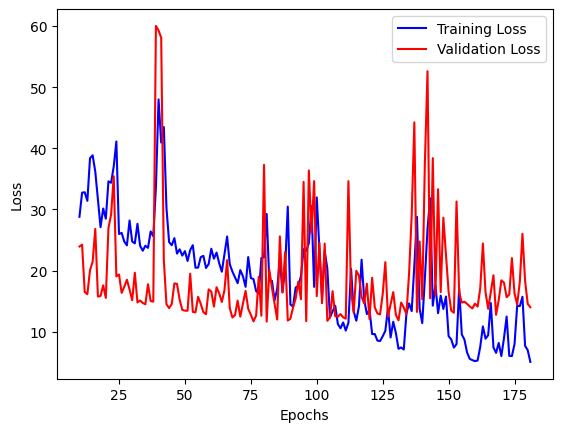

In [ ]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We see that the model begins to over fit for high epochs and this is where the early stopping stops the models from training

In [ ]:
from keras.models import load_model
saved_model = load_model('basic_model.h5')
train_acc = saved_model.evaluate(train_data, train_labels, verbose=0)
test_acc = saved_model.evaluate(test_data, test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 14.208, Test: 17.417


In [ ]:
# Evaluate the model on the test set
test_loss = saved_model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)


1/1 [==============================] - 0s 152ms/step - loss: 17.4171
Test Loss: 17.417123794555664


In [ ]:
predictions = saved_model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 93ms/step
Mean Squared Error: 17.417124618923047
Mean Absolute Error: 3.4120225452241444
R-squared: 0.10478415420220688


The model has improved a very small amount

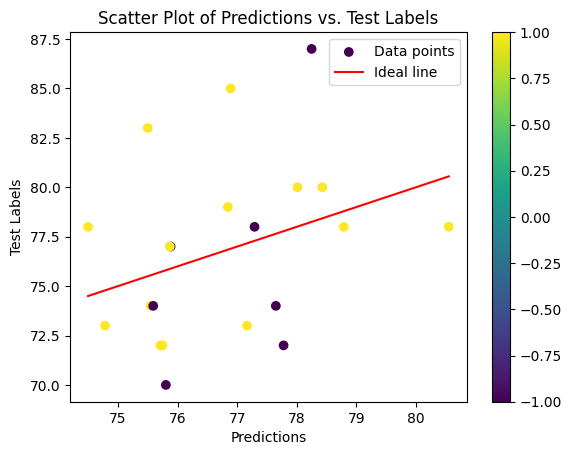

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Data points')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



Somehow sex is now more scattered, we can still try adding it as a feature to see if it helps


###  V3
Adding sex as a feature with early stopping

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate

# Define the input layer for the 3D Convolutional network
input_img = Input(shape=(79, 95, 68, 1))

# Apply 3D Convolutional layers with MaxPooling using the Functional API
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(input_img)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten the output and add Dense layers for age prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_img = Dense(1, activation='linear')(x)

# Define the input layer for the extra feature
input_extra = Input(shape=(1,))

# Concatenate the output of the Convolutional network with the extra feature
merged = concatenate([output_img, input_extra])

# Add Dense layers for further prediction
merged = Dense(4, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks

# Define the model with both inputs and the final output
model = Model(inputs=[input_img, input_extra], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, concatenate

# Define the input layer for the 3D Convolutional network
input_img = Input(shape=(79, 95, 68, 1))

# Apply 3D Convolutional layers with MaxPooling using the Functional API
x = Conv3D(32, kernel_size=(3, 3, 3), activation='relu')(input_img)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Conv3D(64, kernel_size=(3, 3, 3), activation='relu')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten the output and add Dense layers for age prediction
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output_img = Dense(16, activation='linear')(x)

# Define the input layer for the extra feature
input_extra = Input(shape=(1,))

# Concatenate the output of the Convolutional network with the extra feature
merged = concatenate([output_img, input_extra])

# Add Dense layers for further prediction
merged = Dense(8, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks

# Define the model with both inputs and the final output
model = Model(inputs=[input_img, input_extra], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


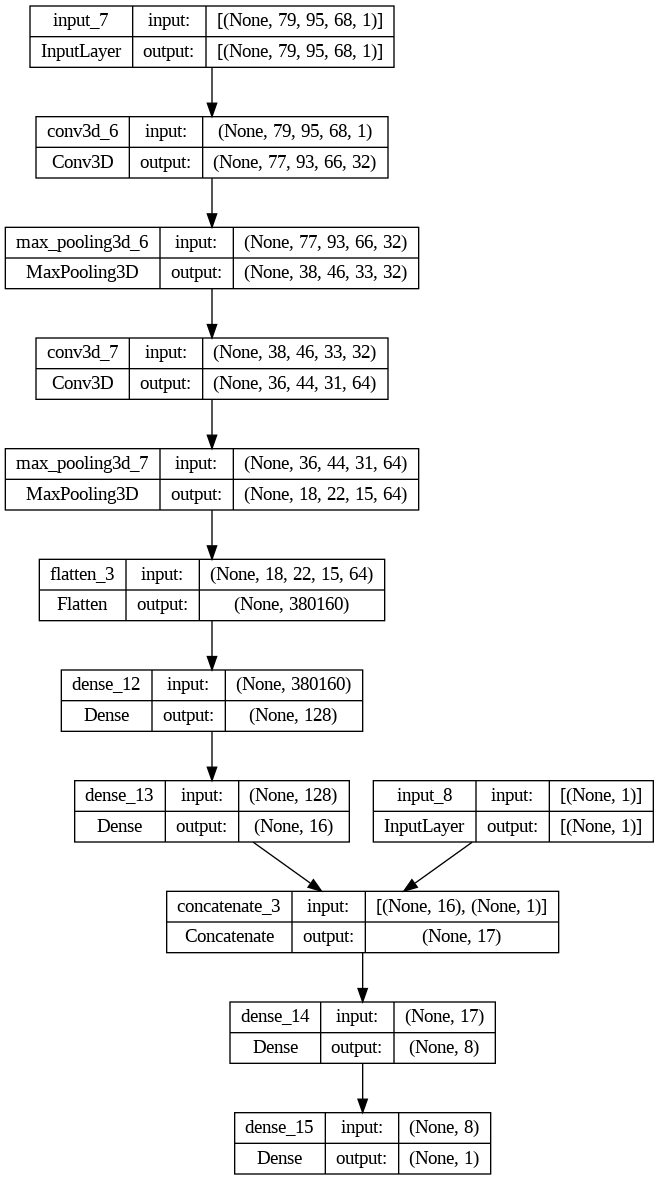

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=100),
             ModelCheckpoint(filepath='basic_sex_model.h5', monitor='val_loss', save_best_only=True)]

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 6828.8145 - val_loss: 4467.8594
Epoch 2/100
4/4 [==============================] - 3s 951ms/step - loss: 4400.7495 - val_loss: 3781.1741
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 2814.3694 - val_loss: 778.1365
Epoch 4/100
4/4 [==============================] - 1s 305ms/step - loss: 420.5643 - val_loss: 1214.3479
Epoch 5/100
4/4 [==============================] - 4s 1s/step - loss: 869.3428 - val_loss: 41.4731
Epoch 6/100
4/4 [==============================] - 1s 306ms/step - loss: 147.5361 - val_loss: 412.9963
Epoch 7/100
4/4 [==============================] - 1s 307ms/step - loss: 404.7803 - val_loss: 168.4288
Epoch 8/100
4/4 [==============================] - 1s 308ms/step - loss: 75.8432 - val_loss: 111.7802
Epoch 9/100
4/4 [==============================] - 1s 305ms/step - loss: 161.4918 - val_loss: 101.1150
Epoch 10/100
4/4 [==============================] - 1s 305ms/step - loss: 51.0

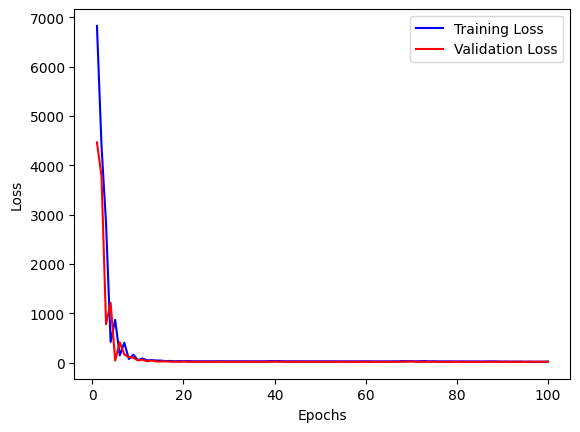

In [ ]:
# Run model.fit() and store the training history
history = model.fit([train_data, train_sex], train_labels, epochs=100, batch_size=16, validation_split=0.2, callbacks = callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

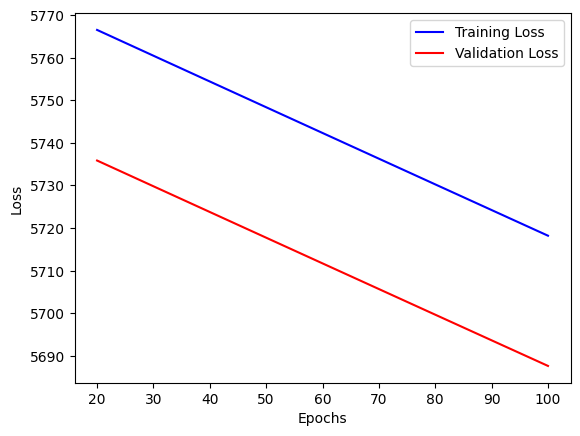

In [ ]:
epochs = range(20, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[19:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[19:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
saved_model = load_model('basic_sex_model.h5')
train_acc = saved_model.evaluate([train_data, train_sex], train_labels, verbose=0)
test_acc = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 20.991, Test: 18.977


In [ ]:
predictions = saved_model.predict([test_data, test_sex])
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 98ms/step
Mean Squared Error: 18.97686843771953
Mean Absolute Error: 3.5381048293340776
R-squared: 0.024615503375953973


The model has improved slightly

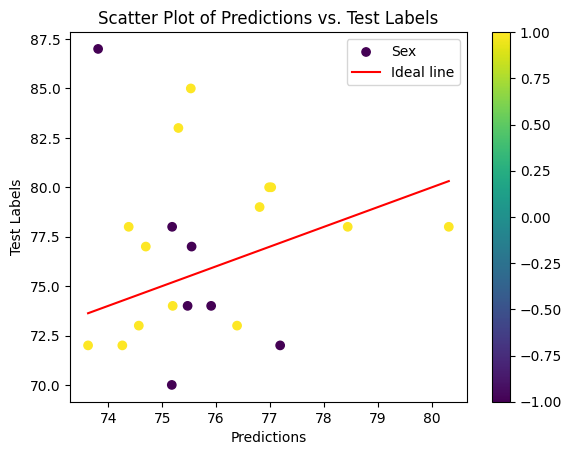

In [ ]:
# Assuming you have your data for predictions, test_labels, and sex_train
# Create a scatter plot
plt.scatter(predictions, test_labels, c=test_sex, cmap='viridis', label='Sex')
plt.plot([min(predictions), max(predictions)], [min(predictions), max(predictions)], c='red', label='Ideal line')

# Add labels and title
plt.xlabel('Predictions')
plt.ylabel('Test Labels')
plt.title('Scatter Plot of Predictions vs. Test Labels')

# Add a legend
plt.legend()

# Show the plot
plt.colorbar()  # Add a colorbar to show the mapping of colors to sex_train values
plt.show()



We see that after adding sex the poins are more equally spread however the model still does not perform too well, perhaps tuning the model will help

### V4
Tuning the model with bayesian optimisation, this is more effecient than grid and random search (typically)

In [ ]:
pip install optuna

In [ ]:
import time
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adam
import traceback
import gc

def create_model(kernel_size, num_layers, neurons1, neurons2, neurons3, learning_rate, dilation_rate, pool_size, dropout = 0.2, activation = 'relu', strides=(1,1,1), padding='same'):
  # Define the input layer for the 3D Convolutional network
  input_img = Input(shape=(79, 95, 68, 1))
  x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(input_img)
  x = MaxPooling3D(pool_size=pool_size)(x)
  x = Dropout(dropout)(x)
  # Apply 3D Convolutional layers with MaxPooling using the Functional API
  for i in range(num_layers):
    try:
      x = Conv3D(neurons1, kernel_size=kernel_size, activation=activation)(x)
      x = MaxPooling3D(pool_size=pool_size)(x)
      x = Dropout(dropout)(x)
    except:
      traceback.print_exc()
      return(999)
  # Flatten the output and add Dense layers for age prediction
  x = Flatten()(x)
  x = Dense(neurons2, activation=activation)(x)
  output_img = Dense(16, activation='relu')(x)
  # Define the input layer for the extra feature
  input_extra = Input(shape=(1,))
  # Concatenate the output of the Convolutional network with the extra feature
  merged = concatenate([output_img, input_extra])
  # Add Dense layers for further prediction
  merged = Dense(neurons3, activation=activation)(merged)
  output = Dense(1, activation='linear')(merged)  # Use 'linear' activation for regression tasks
  # Define the model with both inputs and the final output
  model = Model(inputs=[input_img, input_extra], outputs=output)
  optimizer = Adam(learning_rate=learning_rate)
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model




def objective(trial):
    callbacks = [EarlyStopping(monitor='val_loss', patience=40),
             ModelCheckpoint(filepath='bayesian_model.h5', monitor='val_loss', save_best_only=True)]
    """return the mse"""
    num_layers = trial.suggest_int('num_layers', low = 1, high = 2, step = 1)
    neurons1 = trial.suggest_int('neurons1', low = 2, high = 16, step = 4)
    neurons2 = trial.suggest_int('neurons2', low = 2, high = 16, step = 4)
    neurons3 = trial.suggest_int('neurons3', low = 2, high = 16, step = 4)
    batch_size = trial.suggest_int('batch_size', low = 8, high = 32, step = 8)
    learning_rate = trial.suggest_float('learning_rate', low = 0.00001, high = 0.01, step = 0.0005)

    kernel_size = trial.suggest_int('kernel_size', low = 3, high =5, step =1)
    dilation_rate = trial.suggest_int('dilation_rate', low = 1, high =3, step =1)
    pool_size = trial.suggest_int('pool_size', low = 1, high =2, step =1)

    # random forest classifier object
    model = create_model(kernel_size = (kernel_size,kernel_size,kernel_size), num_layers = num_layers, neurons1 = neurons1, neurons2 = neurons2, neurons3 = neurons3, learning_rate = learning_rate, dilation_rate=(dilation_rate,dilation_rate,dilation_rate), pool_size=(pool_size,pool_size,pool_size))
    print(model.summary())
    try:
      model.fit([train_data, train_sex], train_labels, epochs=100, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
    except:
      traceback.print_exc()
      del model
      gc.collect()
      tf.keras.backend.clear_session()
      return(50)
      #res = model.evaluate([test_data, test_sex], test_labels, verbose=0)
    try:
      saved_model = load_model('bayesian_model.h5')
      res = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
      del model
      del saved_model
      gc.collect()
      tf.keras.backend.clear_session()
      #!rm bayesian_model.h5
      return(res)
    except:
      traceback.print_exc()
      print('callback error')
      del model
      gc.collect()
      tf.keras.backend.clear_session()
      return(50)


# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='minimize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=50, gc_after_trial=True)
time_bayesian = time.time() - time_start

columns = ['Number of iterations', 'Iteration Number of Optimal Hyperparamters', 'Score', 'Time Elapsed (s)']

# store result in a data frame
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

[I 2023-08-17 12:35:14,442] A new study created in memory with name: no-name-ca8a6d90-df42-41cd-ae31-263446f76ef0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 71, 87, 60,   756         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 30,   0           ['conv3d[0][0]']                 
                                6)                                                            

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:700: UserWarning:

The distribution is specified by [2, 32] and step=4, but the range is not divisible by `step`. It will be replaced by [2, 30].

/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:685: UserWarning:

The distribution is specified by [1e-05, 0.1] and step=0.0005, but the range is not divisible by `step`. It will be replaced by [1e-05, 0.09951].



                                                                                                  
Total params: 32,257
Trainable params: 32,257
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/200
2/2 [==============================] - 5s 929ms/step - loss: 299685472.0000 - val_loss: 5256.5552
Epoch 2/200
2/2 [==============================] - 1s 221ms/step - loss: 43597800.0000 - val_loss: 363501.8750
Epoch 3/200
2/2 [==============================] - 1s 214ms/step - loss: 420669.7188 - val_loss: 5758.2222
Epoch 4/200
2/2 [==============================] - 1s 194ms/step - loss: 5787.6182 - val_loss: 5731.0371
Epoch 5/200
2/2 [==============================] - 1s 212ms/step - loss: 5768.0200 - val_loss: 5722.2812
Epoch 6/200
2/2 [==============================] - 1s 194ms/step - loss: 5758.7119 - val_loss: 5699.4873
Epoch 7/200
2/2 [==============================] - 1s 196ms/step - loss: 5734.2188 -

[I 2023-08-17 12:36:12,718] Trial 0 finished with value: 20.59441375732422 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 26, 'neurons3': 10, 'batch_size': 48, 'learning_rate': 0.04601, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 0 with value: 20.59441375732422.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-17 12:38:43,705] Trial 1 finished with value: 21.52981948852539 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 2, 'neurons3': 18, 'batch_size': 24, 'learning_rate': 0.02551, 'kernel_size': 3, 'dilation_rate': 1, 'pool_size': 1}. Best is trial 0 with value: 20.59441375732422.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 70, 86, 59,   1950        ['input_1[0][0]']                
                                30)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 29,   0           ['conv3d[0][0]']                 
                                30)                                                           

[I 2023-08-17 12:39:53,875] Trial 2 finished with value: 22.464279174804688 and parameters: {'num_layers': 2, 'neurons1': 30, 'neurons2': 2, 'neurons3': 30, 'batch_size': 32, 'learning_rate': 0.08701, 'kernel_size': 4, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 0 with value: 20.59441375732422.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   756         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-17 12:41:46,957] Trial 3 finished with value: 460.0929260253906 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 18, 'neurons3': 18, 'batch_size': 48, 'learning_rate': 1e-05, 'kernel_size': 5, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 0 with value: 20.59441375732422.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 73, 89, 62,   0           ['conv3d[0][0]']                 
                                22)                                                           

Traceback (most recent call last):
  File "<ipython-input-28-2e32d069c333>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=200, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[48,71,87,60,22] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv3d_1/Relu-0-1-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOpt

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 12:43:10,625] Trial 5 finished with value: 20.463205337524414 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 6, 'batch_size': 32, 'learning_rate': 0.03551000000000001, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   1690        ['input_1[0][0]']                
                                26)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 73, 89, 62,   0           ['conv3d[0][0]']                 
                                26)                                                           

Traceback (most recent call last):
  File "<ipython-input-28-2e32d069c333>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=200, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'model/max_pooling3d_1/MaxPool3D' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 70, 86, 59,   1690        ['input_1[0][0]']                
                                26)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 29,   0           ['conv3d[0][0]']                 
                                26)                                                           

[I 2023-08-17 12:47:01,254] Trial 7 finished with value: 4020.568359375 and parameters: {'num_layers': 1, 'neurons1': 26, 'neurons2': 2, 'neurons3': 22, 'batch_size': 24, 'learning_rate': 0.06451, 'kernel_size': 4, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   1950        ['input_1[0][0]']                
                                30)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 73, 89, 62,   0           ['conv3d[0][0]']                 
                                30)                                                           

[I 2023-08-17 12:55:58,926] Trial 8 finished with value: 22.059112548828125 and parameters: {'num_layers': 1, 'neurons1': 30, 'neurons2': 30, 'neurons3': 30, 'batch_size': 8, 'learning_rate': 0.050010000000000006, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 1}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   2772        ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 12:57:45,565] Trial 9 finished with value: 25.100154876708984 and parameters: {'num_layers': 1, 'neurons1': 22, 'neurons2': 14, 'neurons3': 22, 'batch_size': 40, 'learning_rate': 0.09151, 'kernel_size': 5, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:01:10,174] Trial 10 finished with value: 5305.15966796875 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 10, 'neurons3': 2, 'batch_size': 64, 'learning_rate': 0.02101, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 71, 87, 60,   1764        ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 30,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:03:55,372] Trial 11 finished with value: 20.5556583404541 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 22, 'neurons3': 6, 'batch_size': 64, 'learning_rate': 0.03001, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 71, 87, 60,   1764        ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 30,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:07:20,234] Trial 12 finished with value: 5484.1083984375 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 22, 'neurons3': 2, 'batch_size': 64, 'learning_rate': 0.02851, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 5 with value: 20.463205337524414.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:08:38,826] Trial 13 finished with value: 17.16908836364746 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 10, 'neurons3': 6, 'batch_size': 8, 'learning_rate': 0.00801, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:09:15,635] Trial 14 finished with value: 48.71684265136719 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 10, 'neurons3': 10, 'batch_size': 8, 'learning_rate': 0.00151, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:10:35,220] Trial 15 finished with value: 20.51754379272461 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 6, 'neurons3': 6, 'batch_size': 16, 'learning_rate': 0.01201, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   280         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:11:18,983] Trial 16 finished with value: 20.742704391479492 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 10, 'neurons3': 10, 'batch_size': 16, 'learning_rate': 0.06951, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 77, 93, 66,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 13:18:41,406] Trial 17 finished with value: 21.064586639404297 and parameters: {'num_layers': 2, 'neurons1': 22, 'neurons2': 6, 'neurons3': 6, 'batch_size': 16, 'learning_rate': 0.03701, 'kernel_size': 3, 'dilation_rate': 1, 'pool_size': 1}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   130         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-17 13:18:57,109] Trial 18 finished with value: 18.520231246948242 and parameters: {'num_layers': 2, 'neurons1': 2, 'neurons2': 6, 'neurons3': 2, 'batch_size': 40, 'learning_rate': 0.011009999999999999, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   130         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-17 13:19:48,359] Trial 19 finished with value: 20.613473892211914 and parameters: {'num_layers': 2, 'neurons1': 2, 'neurons2': 6, 'neurons3': 2, 'batch_size': 40, 'learning_rate': 0.01401, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 76, 92, 65,   130         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 76, 92, 65,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-17 13:21:51,089] Trial 20 finished with value: 21.4260196685791 and parameters: {'num_layers': 1, 'neurons1': 2, 'neurons2': 14, 'neurons3': 14, 'batch_size': 56, 'learning_rate': 0.01151, 'kernel_size': 4, 'dilation_rate': 1, 'pool_size': 1}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   280         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:22:47,868] Trial 21 finished with value: 20.189687728881836 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 6, 'neurons3': 6, 'batch_size': 24, 'learning_rate': 0.03751, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   280         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:23:31,701] Trial 22 finished with value: 27.2296085357666 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 10, 'neurons3': 2, 'batch_size': 24, 'learning_rate': 0.01851, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:24:56,295] Trial 23 finished with value: 24.44158363342285 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 6, 'neurons3': 10, 'batch_size': 8, 'learning_rate': 0.041010000000000005, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   56          ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-17 13:25:08,999] Trial 24 finished with value: 161.37185668945312 and parameters: {'num_layers': 2, 'neurons1': 2, 'neurons2': 14, 'neurons3': 6, 'batch_size': 40, 'learning_rate': 0.00901, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-17 13:26:45,541] Trial 25 finished with value: 5220.2568359375 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 6, 'neurons3': 2, 'batch_size': 16, 'learning_rate': 0.00601, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:28:28,235] Trial 26 finished with value: 20.740856170654297 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 10, 'neurons3': 6, 'batch_size': 24, 'learning_rate': 0.01701, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:29:55,253] Trial 27 finished with value: 257.25677490234375 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 18, 'neurons3': 14, 'batch_size': 32, 'learning_rate': 0.07551, 'kernel_size': 3, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   130         ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                2)                                                            

[I 2023-08-17 13:30:17,571] Trial 28 finished with value: 21.480663299560547 and parameters: {'num_layers': 2, 'neurons1': 2, 'neurons2': 6, 'neurons3': 10, 'batch_size': 8, 'learning_rate': 0.02451, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   390         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-17 13:32:41,468] Trial 29 finished with value: 5620.1865234375 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 14, 'neurons3': 2, 'batch_size': 56, 'learning_rate': 0.04301000000000001, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 71, 87, 60,   1260        ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 35, 43, 30,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 13:34:29,759] Trial 30 finished with value: 20.621858596801758 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 10, 'neurons3': 6, 'batch_size': 40, 'learning_rate': 0.032510000000000004, 'kernel_size': 5, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:35:52,882] Trial 31 finished with value: 20.404203414916992 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 10, 'batch_size': 32, 'learning_rate': 0.040010000000000004, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:36:47,801] Trial 32 finished with value: 25.90618324279785 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 10, 'batch_size': 24, 'learning_rate': 0.06001, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 13:37:57,587] Trial 33 finished with value: 24.944129943847656 and parameters: {'num_layers': 2, 'neurons1': 22, 'neurons2': 2, 'neurons3': 10, 'batch_size': 32, 'learning_rate': 0.040010000000000004, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:39:09,675] Trial 34 finished with value: 21.849321365356445 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 6, 'batch_size': 48, 'learning_rate': 0.04701, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:40:30,100] Trial 35 finished with value: 20.578237533569336 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 6, 'neurons3': 14, 'batch_size': 24, 'learning_rate': 0.02451, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 77, 93, 66,   168         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 38, 46, 33,   0           ['conv3d[0][0]']                 
                                6)                                                            

[I 2023-08-17 13:42:54,139] Trial 36 finished with value: 2920.795166015625 and parameters: {'num_layers': 2, 'neurons1': 6, 'neurons2': 2, 'neurons3': 2, 'batch_size': 40, 'learning_rate': 0.00151, 'kernel_size': 3, 'dilation_rate': 1, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 70, 86, 59,   1690        ['input_1[0][0]']                
                                26)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 70, 86, 59,   0           ['conv3d[0][0]']                 
                                26)                                                           

Traceback (most recent call last):
  File "<ipython-input-28-2e32d069c333>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=200, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'model/max_pooling3d_2/MaxPool3D' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:44:02,635] Trial 38 finished with value: 47.34505844116211 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 6, 'batch_size': 48, 'learning_rate': 0.00651, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 13:47:11,259] Trial 39 finished with value: 3970.155517578125 and parameters: {'num_layers': 1, 'neurons1': 22, 'neurons2': 10, 'neurons3': 10, 'batch_size': 16, 'learning_rate': 0.05451, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 70, 86, 59,   1690        ['input_1[0][0]']                
                                26)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 70, 86, 59,   0           ['conv3d[0][0]']                 
                                26)                                                           

Traceback (most recent call last):
  File "<ipython-input-28-2e32d069c333>", line 64, in objective
    model.fit([train_data, train_sex], train_labels, epochs=200, batch_size= batch_size, validation_split=0.2, callbacks = callbacks)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node 'model/max_pooling3d_2/MaxPool3D' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:48:39,671] Trial 41 finished with value: 20.56124496459961 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 2, 'neurons3': 6, 'batch_size': 32, 'learning_rate': 0.03601000000000001, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:49:43,404] Trial 42 finished with value: 22.76357650756836 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 6, 'neurons3': 26, 'batch_size': 24, 'learning_rate': 0.04651, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 13:52:54,979] Trial 43 finished with value: 4161.486328125 and parameters: {'num_layers': 2, 'neurons1': 22, 'neurons2': 2, 'neurons3': 2, 'batch_size': 40, 'learning_rate': 0.032510000000000004, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   504         ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 13:54:53,535] Trial 44 finished with value: 20.545509338378906 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 6, 'neurons3': 6, 'batch_size': 32, 'learning_rate': 0.02101, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 13:58:04,727] Trial 45 finished with value: 3875.57763671875 and parameters: {'num_layers': 1, 'neurons1': 14, 'neurons2': 2, 'neurons3': 2, 'batch_size': 32, 'learning_rate': 0.05901000000000001, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 67, 83, 56,   2268        ['input_1[0][0]']                
                                18)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 33, 41, 28,   0           ['conv3d[0][0]']                 
                                18)                                                           

[I 2023-08-17 14:01:29,805] Trial 46 finished with value: 20.778839111328125 and parameters: {'num_layers': 2, 'neurons1': 18, 'neurons2': 6, 'neurons3': 6, 'batch_size': 40, 'learning_rate': 0.05101000000000001, 'kernel_size': 5, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 75, 91, 64,   616         ['input_1[0][0]']                
                                22)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 37, 45, 32,   0           ['conv3d[0][0]']                 
                                22)                                                           

[I 2023-08-17 14:02:17,503] Trial 47 finished with value: 131.14732360839844 and parameters: {'num_layers': 2, 'neurons1': 22, 'neurons2': 26, 'neurons3': 10, 'batch_size': 48, 'learning_rate': 0.02701, 'kernel_size': 3, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   392         ['input_1[0][0]']                
                                14)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                14)                                                           

[I 2023-08-17 14:03:41,526] Trial 48 finished with value: 22.277896881103516 and parameters: {'num_layers': 2, 'neurons1': 14, 'neurons2': 10, 'neurons3': 14, 'batch_size': 24, 'learning_rate': 0.034510000000000006, 'kernel_size': 3, 'dilation_rate': 3, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 95, 68,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 73, 89, 62,   650         ['input_1[0][0]']                
                                10)                                                               
                                                                                                  
 max_pooling3d (MaxPooling3D)   (None, 36, 44, 31,   0           ['conv3d[0][0]']                 
                                10)                                                           

[I 2023-08-17 14:06:16,409] Trial 49 finished with value: 2390.579345703125 and parameters: {'num_layers': 2, 'neurons1': 10, 'neurons2': 18, 'neurons3': 2, 'batch_size': 16, 'learning_rate': 0.03901, 'kernel_size': 4, 'dilation_rate': 2, 'pool_size': 2}. Best is trial 13 with value: 17.16908836364746.


In [ ]:
values = [study.trials[i].values[0] for i in range(len(study.trials))]
params = [study.trials[i].params for i in range(len(study.trials))]
columns = list(params[0].keys()) + ['val']
bayesian_results = pd.DataFrame(columns = columns)
bayesian_results['val'] = values
for param in list(params[0].keys()):
  param_list = [study[param] for study in params]
  bayesian_results[param] = param_list

In [ ]:
bayesian_results.sort_values(by=['val'])

,num_layers,neurons1,neurons2,neurons3,batch_size,learning_rate,kernel_size,dilation_rate,pool_size,val
13,2,18,10,6,8,0.00801,3,2,2,17.169088
18,2,2,6,2,40,0.01101,4,2,2,18.520231
21,2,10,6,6,24,0.03751,3,2,2,20.189688
31,2,18,2,10,32,0.04001,3,3,2,20.404203
5,2,18,2,6,32,0.03551,3,3,2,20.463205
15,2,18,6,6,16,0.01201,3,2,2,20.517544
44,2,18,6,6,32,0.02101,3,3,2,20.545509
11,2,14,22,6,64,0.03001,5,2,2,20.555658
41,2,18,2,6,32,0.03601,3,3,2,20.561245
35,2,14,6,14,24,0.02451,3,3,2,20.578238


In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

Tuning the model seems to make no real improvement, therefore other approaches must be taken, transfer learning can help as we only have 100 images

### V5

In [ ]:
pip install classification-models-3D

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.8 MB/s eta 0:00:00


In [ ]:
pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00


In [ ]:
from classification_models_3D.tfkeras import Classifiers

vgg19, preprocess_input = Classifiers.get('vgg19')
pretrained_model = vgg19(input_shape=(79, 95, 68, 3), weights='imagenet')

In [ ]:
image_data.shape

(102, 79, 95, 68, 1)

ASthis cnn takes in rgb input we must duplicate each image twice so that the input shapes match

In [ ]:
duplicated_data = np.repeat(image_data, 3, axis=-1)
print(duplicated_data.shape)

(102, 79, 95, 68, 3)


In [ ]:
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(duplicated_data, sexes, ages, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

for layer in pretrained_model.layers:
    model.add(layer)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in model.layers:
    layer.trainable = False


# Flatten the output of the pre-trained model
x = Flatten()(model.output)

# Add Dense layers after concatenation
x = Dense(32, activation='relu')(x)

additional_input = Input(shape=(1,))

# Concatenate the flattened output with the new input
concatenated = concatenate([x, additional_input])
output = Dense(1, activation='linear')(concatenated)  # Use 'linear' activation for regression tasks

# Create the final model
model = Model(inputs=[pretrained_model.input, additional_input], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

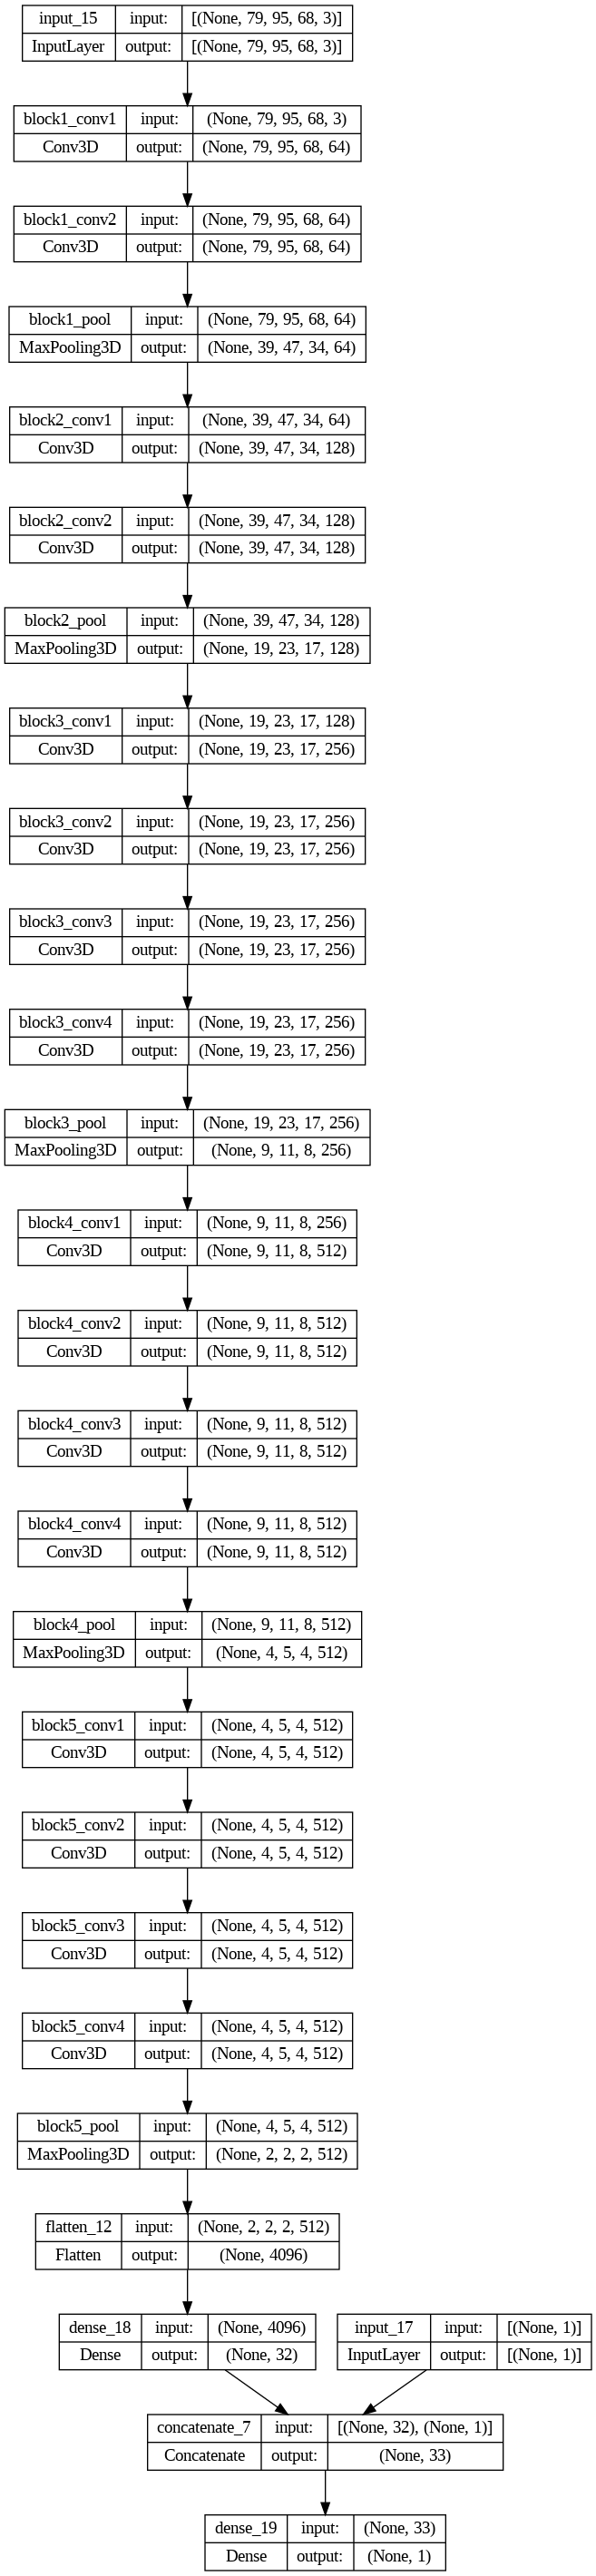

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 5176.6167 - val_loss: 4463.7065
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 3982.0000 - val_loss: 3359.2883
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2929.2737 - val_loss: 2389.3027
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 2025.8621 - val_loss: 1581.1060
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 1288.4336 - val_loss: 955.9838
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 750.2000 - val_loss: 510.8414
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 380.1790 - val_loss: 236.3372
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 167.3687 - val_loss: 92.6683
Epoch 9/100
8/8 [==============================] - 9s 1s/step - loss: 67.6073 - val_loss: 33.7261
Epoch 10/100
8/8 [==============================] - 9s 1s/step - loss: 36.2149 - val_loss: 

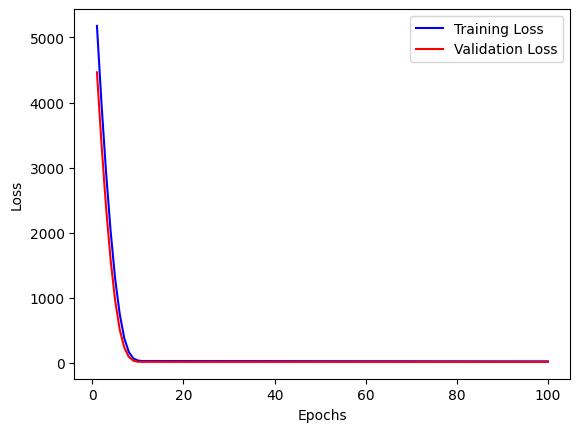

In [ ]:
import matplotlib.pyplot as plt
callbacks = [EarlyStopping(monitor='val_loss', patience=40),
             ModelCheckpoint(filepath='TL_model.h5', monitor='val_loss', save_best_only=True)]
# Run model.fit() and store the training history
history = model.fit([train_data, train_sex], train_labels, epochs=100, batch_size=8, validation_split=0.2, callbacks=callbacks)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
saved_model = load_model('TL_model.h5')
res = saved_model.evaluate([test_data, test_sex], test_labels, verbose=0)
print(res)

21.277732849121094


In [ ]:
model.evaluate([test_data, test_sex], test_labels, verbose=0)

21.681306838989258

## 2D

### Creating the 2D data

In [25]:
twod_df = pd.DataFrame(columns = ['id','age','sex','entropy','data'])

In [ ]:
from skimage.filters import rank
from skimage.feature import greycomatrix
from skimage import img_as_ubyte
count = 0
for image, age, sex in zip(image_data, ages, sexes):
  count += 1
  for i in range(79):
    slice_ = image[i]
    min_val = np.min(slice_)
    max_val = np.max(slice_)
    im = 2 * (slice_ - min_val) / (max_val - min_val) - 1
    image_8bit = img_as_ubyte(im[:,:,0])
    # 'distances' and 'angles' are parameters that define the relative pixel pairs you're interested in.
    # For example, using distances=[1] and angles=[0] considers pixel pairs that are horizontally adjacent.
    glcm = greycomatrix(image_8bit, distances=[1], angles=[0], symmetric=True, normed=True)
    glcm_probabilities = glcm.ravel()  # Flatten the GLCM to get probabilities
    glcm_entropy = -np.sum(glcm_probabilities * np.log2(glcm_probabilities + np.finfo(float).eps))  # Add a small value to avoid log(0)
    new_row = {'id':count, 'age':age, 'sex':sex, 'entropy':glcm_entropy, 'data':slice_}
    twod_df = twod_df.append(new_row, ignore_index=True)


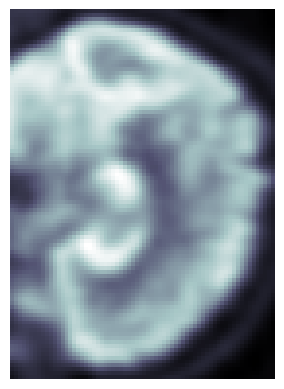

In [27]:
plt.imshow(twod_df['data'][1469], cmap='bone')
plt.axis('off')
plt.show()
# Syntax

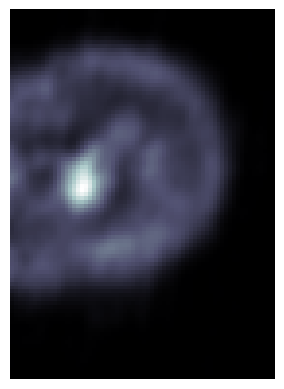

In [28]:
plt.imshow(twod_df['data'][7107], cmap='bone')
plt.axis('off')
plt.show()
# Syntax

In [ ]:
high_entropy_df = pd.DataFrame(columns = ['id','age','sex','entropy','data'])
for id in twod_df.id.unique():
  filtered_df = twod_df[twod_df.id == id].sort_values(by=['entropy'], ascending=False).head(20)
  high_entropy_df = high_entropy_df.append(filtered_df)



In [69]:
high_entropy_df

,id,age,sex,entropy,data
42,1,72,1,7.142260,"[[[0.16140475869178772], [0.1520748883485794],..."
49,1,72,1,7.072617,"[[[0.16961686313152313], [0.1752089560031891],..."
55,1,72,1,7.067529,"[[[0.17936526238918304], [0.18015316128730774]..."
20,1,72,1,7.065411,"[[[0.13445860147476196], [0.13622955977916718]..."
54,1,72,1,7.048630,"[[[0.18338270485401154], [0.18540500104427338]..."
...,...,...,...,...,...
8000,102,81,-1,7.484056,"[[[0.021748237311840057], [0.03057765960693359..."
8025,102,81,-1,7.471582,"[[[0.1531139314174652], [0.17915335297584534],..."
8008,102,81,-1,7.435601,"[[[0.09802068024873734], [0.12609460949897766]..."
7996,102,81,-1,7.428010,"[[[0.0038360031321644783], [0.0073170070536434..."


In [94]:
test_df = high_entropy_df.iloc[-120:]
train_df =  high_entropy_df.iloc[:-120]

In [96]:
td_ages =np.array(train_df['age'])
td_sexes =np.array(train_df['sex'])
td_data =np.array(train_df['data'])
td_entropy = np.array(train_df['entropy'])

In [97]:
td_ages_test =np.array(test_df['age'])
td_sexes_test =np.array(test_df['sex'])
td_data_test =np.array(test_df['data'])
td_entropy_test = np.array(test_df['entropy'])

In [98]:
td_data = np.array([td_data[i] for i in range(len(td_data))])

### V1

In [75]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [104]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(td_data, td_sexes, td_ages, test_size=0.001, random_state=42)

In [105]:
train_data = np.asarray(train_data).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')

In [106]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(95, 68, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(95, 68, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/200
96/96 [==============================] - 2s 8ms/step - loss: 291.4859 - val_loss: 35.3327
Epoch 2/200
96/96 [==============================] - 1s 5ms/step - loss: 28.6546 - val_loss: 29.6671
Epoch 3/200
96/96 [==============================] - 1s 5ms/step - loss: 26.0788 - val_loss: 23.0779
Epoch 4/200
96/96 [==============================] - 1s 5ms/step - loss: 25.6067 - val_loss: 29.3535
Epoch 5/200
96/96 [==============================] - 1s 5ms/step - loss: 23.9351 - val_loss: 22.2507
Epoch 6/200
96/96 [==============================] - 0s 5ms/step - loss: 25.2466 - val_loss: 34.4811
Epoch 7/200
96/96 [==============================] - 0s 5ms/step - loss: 22.6547 - val_loss: 32.5423
Epoch 8/200
96/96 [==============================] - 0s 5ms/step - loss: 21.7029 - val_loss: 18.3082
Epoch 9/200
96/96 [==============================] - 0s 5ms/step - loss: 21.0716 - val_loss: 16.8948
Epoch 10/200
96/96 [==============================] - 0s 5ms/step - loss: 17.6342 - val_lo

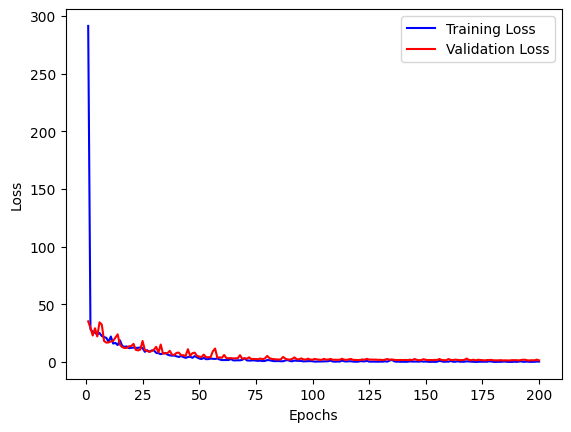

In [107]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=200, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
predictions = model.predict(test_data)
# Calculate different evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

1/1 [==============================] - 0s 171ms/step
Mean Squared Error: 1.494239434262272
Mean Absolute Error: 0.8547576904296875
R-squared: 0.9390355187979489


In [109]:
second_test = np.array([td_data_test[i] for i in range(len(td_data_test))])

In [123]:
predictions_ = model.predict(second_test)

4/4 [==============================] - 0s 3ms/step


In [129]:
predictions_avg = [np.mean(predictions_[i*20:(i+1)*20]) for i in range(6)]

In [130]:
predictions_avg

[74.95063, 77.00569, 71.755936, 75.77751, 71.781334, 79.709694]

In [131]:
test_ages_together = [np.mean(td_ages_test[i*20:(i+1)*20]) for i in range(6)]

In [132]:
mse = mean_squared_error(test_ages_together, predictions_avg)
mae = mean_absolute_error(test_ages_together, predictions_avg)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 15.289791321061784
Mean Absolute Error: 2.588512420654297
R-squared: 0.9390355187979489


This is working really well! MAE of 2.6 is excellent, let's try to improve this further

### V2

what if we do not use image entropy at all

In [156]:
test_df = twod_df.iloc[-474:]
train_df =  twod_df.iloc[:-474]

In [157]:
td_ages =np.array(train_df['age'])
td_sexes =np.array(train_df['sex'])
td_data =np.array(train_df['data'])
td_entropy = np.array(train_df['entropy'])

In [158]:
td_ages_test =np.array(test_df['age'])
td_sexes_test =np.array(test_df['sex'])
td_data_test =np.array(test_df['data'])
td_entropy_test = np.array(test_df['entropy'])

In [159]:
td_data = np.array([td_data[i] for i in range(len(td_data))])

In [160]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(td_data, td_sexes, td_ages, test_size=0.001, random_state=42)

In [161]:
train_data = np.asarray(train_data).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')

In [162]:
model = Sequential() # using sequential

# Add 3D Convolutional layers with MaxPooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(95, 68, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(95, 68, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))


# Flatten the output and add Dense layers for age prediction
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression tasks

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/200
379/379 [==============================] - 3s 6ms/step - loss: 126.2617 - val_loss: 29.0230
Epoch 2/200
379/379 [==============================] - 2s 5ms/step - loss: 28.4650 - val_loss: 20.4626
Epoch 3/200
379/379 [==============================] - 2s 5ms/step - loss: 24.8830 - val_loss: 33.6871
Epoch 4/200
379/379 [==============================] - 2s 5ms/step - loss: 22.3746 - val_loss: 18.4729
Epoch 5/200
379/379 [==============================] - 2s 5ms/step - loss: 21.1845 - val_loss: 33.6952
Epoch 6/200
379/379 [==============================] - 2s 5ms/step - loss: 20.4741 - val_loss: 16.1386
Epoch 7/200
379/379 [==============================] - 2s 5ms/step - loss: 18.5897 - val_loss: 14.7974
Epoch 8/200
379/379 [==============================] - 2s 5ms/step - loss: 17.2125 - val_loss: 14.8798
Epoch 9/200
379/379 [==============================] - 2s 5ms/step - loss: 17.3037 - val_loss: 25.0855
Epoch 10/200
379/379 [==============================] - 2s 5ms/step - lo

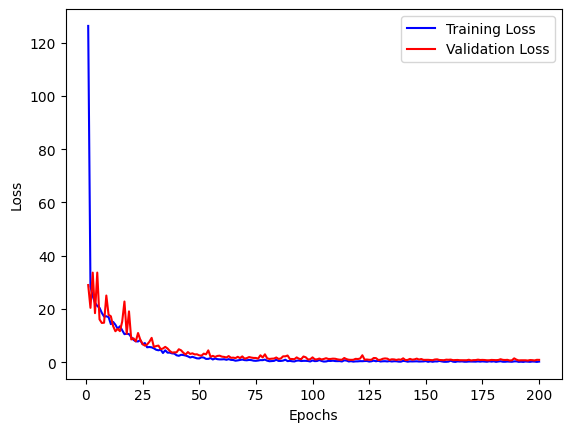

In [163]:
# Run model.fit() and store the training history
history = model.fit(train_data, train_labels, epochs=200, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [164]:
second_test = np.array([td_data_test[i] for i in range(len(td_data_test))])

In [165]:
predictions_ = model.predict(second_test)

15/15 [==============================] - 0s 9ms/step


In [166]:
predictions_avg = [np.mean(predictions_[i*79:(i+1)*79]) for i in range(6)]

In [167]:
predictions_avg

[73.270515, 76.29471, 73.01993, 75.00223, 72.47716, 79.81899]

In [168]:
test_ages_together = [np.mean(td_ages_test[i*79:(i+1)*79]) for i in range(6)]

In [169]:
mse = mean_squared_error(test_ages_together, predictions_avg)
mae = mean_absolute_error(test_ages_together, predictions_avg)

# Display the metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 21.294363847293425
Mean Absolute Error: 3.3517735799153647
R-squared: 0.9390355187979489


we see that using image entropy does indeed help

### V3

Let's use transfer learning to improve the model

In [193]:
from keras.applications.vgg16 import VGG16
pretrained_model = VGG16(input_shape=(95, 68, 3), include_top=False)

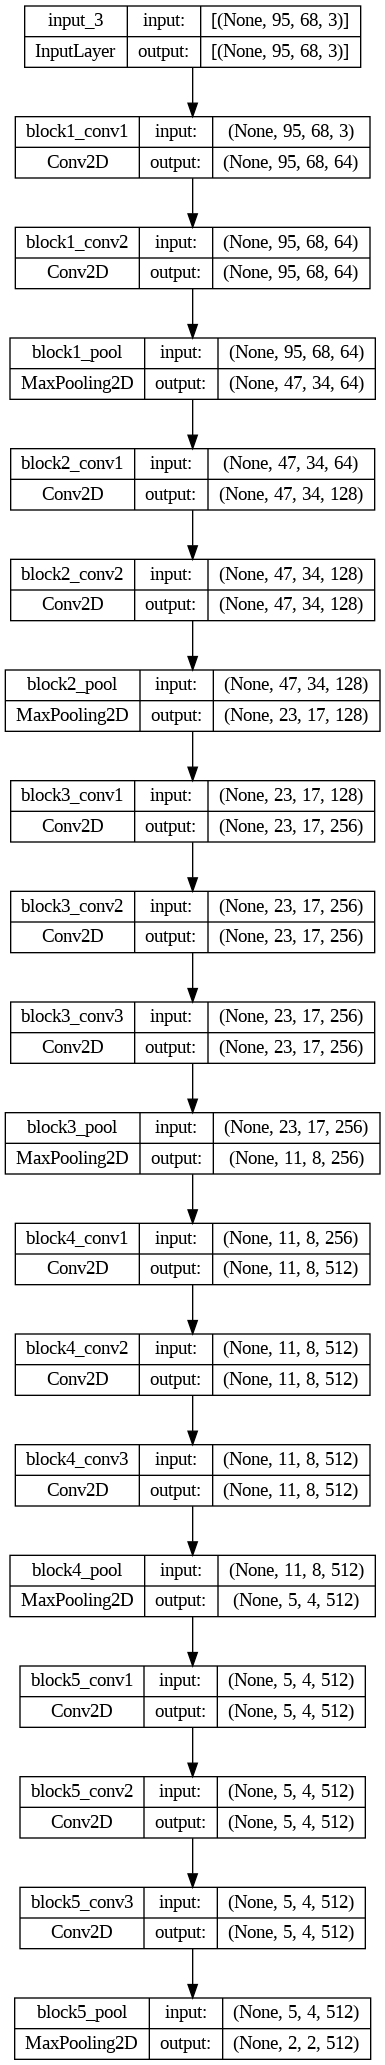

In [191]:
keras.utils.plot_model(pretrained_model, "multi_input_and_output_model.png", show_shapes=True) #vis of architecture


In [180]:
test_df = high_entropy_df.iloc[-120:]
train_df =  high_entropy_df.iloc[:-120]

In [181]:
td_ages =np.array(train_df['age'])
td_sexes =np.array(train_df['sex'])
td_data =np.array(train_df['data'])
td_entropy = np.array(train_df['entropy'])

In [182]:
td_ages_test =np.array(test_df['age'])
td_sexes_test =np.array(test_df['sex'])
td_data_test =np.array(test_df['data'])
td_entropy_test = np.array(test_df['entropy'])

In [183]:
td_data = np.array([td_data[i] for i in range(len(td_data))])

In [184]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_sex, test_sex, train_labels, test_labels = train_test_split(td_data, td_sexes, td_ages, test_size=0.001, random_state=42)

In [185]:
train_data = np.asarray(train_data).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')

In [186]:
train_data.shape

(1918, 95, 68, 1)

In [187]:
duplicated_data = np.repeat(train_data, 3, axis=-1)
print(duplicated_data.shape)

(1918, 95, 68, 3)


In [197]:
model = Sequential()

for layer in pretrained_model.layers:
    model.add(layer)

# Freeze the weights of the pre-trained layers so they are not updated during training
for layer in model.layers:
    layer.trainable = True


# Flatten the output of the pre-trained model
x = Flatten()(model.output)

# Add Dense layers after concatenation
x = Dense(32, activation='relu')(x)


# Concatenate the flattened output with the new input
output = Dense(1, activation='linear')(x)  # Use 'linear' activation for regression tasks

# Create the final model
model = Model(inputs=[pretrained_model.input], outputs=output)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/200
96/96 [==============================] - 12s 57ms/step - loss: 7703063.5000 - val_loss: 31.1770
Epoch 2/200
96/96 [==============================] - 5s 47ms/step - loss: 36.0517 - val_loss: 28.7311
Epoch 3/200
96/96 [==============================] - 5s 48ms/step - loss: 32.1469 - val_loss: 55.4759
Epoch 4/200
96/96 [==============================] - 5s 48ms/step - loss: 37.5077 - val_loss: 31.4090
Epoch 5/200
96/96 [==============================] - 5s 51ms/step - loss: 34.0705 - val_loss: 27.4839
Epoch 6/200
96/96 [==============================] - 5s 48ms/step - loss: 30.7109 - val_loss: 26.7446
Epoch 7/200
96/96 [==============================] - 5s 48ms/step - loss: 31.6519 - val_loss: 26.0994
Epoch 8/200
96/96 [==============================] - 5s 48ms/step - loss: 31.3110 - val_loss: 58.8907
Epoch 9/200
96/96 [==============================] - 5s 48ms/step - loss: 33.5486 - val_loss: 30.7561
Epoch 10/200
96/96 [==============================] - 5s 48ms/step - loss: 3

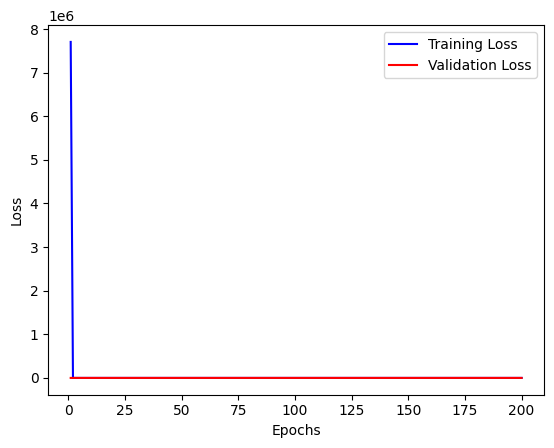

In [198]:
# Run model.fit() and store the training history
history = model.fit(duplicated_data, train_labels, epochs=200, batch_size=16, validation_split=0.2)

# Access the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

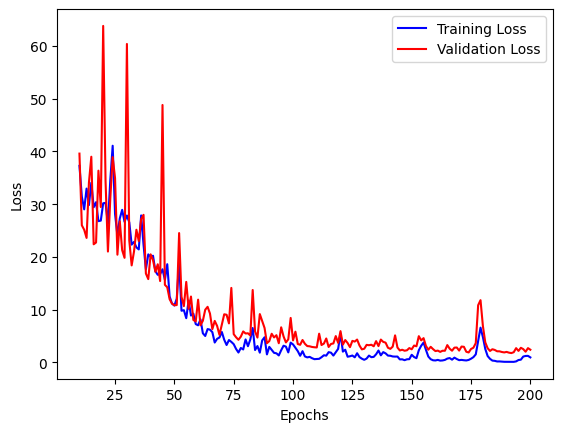

In [199]:
epochs = range(10, len(train_loss) + 1)

# Plot the training and validation curves
plt.plot(epochs, train_loss[9:], 'b', label='Training Loss')
plt.plot(epochs, val_loss[9:], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TL doesnt seem to be helping too much

### V4